In [0]:
import pandas as pd
import numpy as np
import requests, json

api_key = '70D413B2-0123-3524-9634-F730BE441009' 

#years used in study
years = map(str,range(1981,2018))

#states used in study
states = ['IL','IN','IA','KS','KY','MI','MO','NE','OH','SD','WI']

payload = {'key':api_key,
          'source_desc':'SURVEY', 
           'sector_desc':'CROPS',
           'group_desc':'FIELD CROPS',
           'commodity_desc':'CORN', 
           'util_practice_desc':'ALL UTILIZATION PRACTICES', 
           'statisticcat_desc':'PROGRESS',
           'domain_desc':'TOTAL', 
           'state_alpha':states,
           'year':years,
           'format':'JSON'}

#disable copy of slice warning
pd.options.mode.chained_assignment = None  # default='warn'

In [0]:
#df will contain Dented, Dough, Emerged, Mature, Planted, Silking
r = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key='+api_key,params=payload)
df = pd.read_json(json.dumps(r.json()),orient='split')

In [0]:
#Still need harvested phase so change payload to grain which will allow us to access it
payload['util_practice_desc'] = 'GRAIN'
r = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key='+api_key,params=payload)
dfG = pd.read_json(json.dumps(r.json()),orient='split')

In [0]:
#concatenate the two dataframes together because dfG contains that percent harvested while df contains all other phases
#save the raw data incase the gov't shuts down...
df = pd.concat([df,dfG])
df.to_excel('progress_data_raw.xlsx')
df.to_csv('progress_data_raw.csv')

NameError: ignored

In [0]:
#use the saved csv
df = pd.read_csv('progress_data_raw.csv')

In [0]:
#Select state and phase
df = df[df.state_name == 'ILLINOIS']
pl = df['unit_desc'] == 'PCT PLANTED'
dfp = df[['week_ending','Value']][pl]

In [0]:
#This is what unedited df looks like. Dates and values only once per week. Want to change this so have a value every day of the week.
dfp.head(10)

,week_ending,Value
11182,2018-04-01,0
11183,2018-04-08,0
11184,2018-04-15,0
11185,2018-04-22,4
11186,2018-04-29,32
11187,2018-05-06,74
11188,2018-05-13,90
11189,2018-05-20,96
11190,2018-05-27,100
11191,2018-06-03,100


In [0]:
#sanity check to see if picked out state and phase correctly. should return only one value.
dfp[dfp.week_ending == '2017-04-09']

,week_ending,Value
11193,2017-04-09,1


In [0]:
#convert week_ending column to datetime format. set year to index.
dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
dfp.set_index('week_ending', inplace = True)
dfp.head(10)

,Value
week_ending,
2018-04-01,0
2018-04-08,0
2018-04-15,0
2018-04-22,4
2018-04-29,32
2018-05-06,74
2018-05-13,90
2018-05-20,96
2018-05-27,100


In [0]:
#need to extend date range so it runs from 01-01-1981 to 12-31-2017 and has daily points not weekly.

ix = pd.date_range(start= '01-01-1981', end = '12-31-2017', freq = 'D')
dfp = dfp.reindex(ix)

dfp.head()

,Value
1981-01-01,NaN
1981-01-02,NaN
1981-01-03,NaN
1981-01-04,NaN
1981-01-05,NaN


In [0]:
#locate a specific year
#assume 0% progress at start of each year for each phase and 100% progress at end of each year for each phase
df_2017 = dfp.loc['2017']
df_2017.iloc[0,0] = 0
df_2017.iloc[-1] = 100
df_2017.head()

,Value
2017-01-01,0.0
2017-01-02,NaN
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN


In [0]:
#will not work because I have NaN values 
#df_2017.plot()

In [0]:
df_2017.loc['2017-04-09':'2017-04-16']

,Value
2017-04-09,1.0
2017-04-10,NaN
2017-04-11,NaN
2017-04-12,NaN
2017-04-13,NaN
2017-04-14,NaN
2017-04-15,NaN
2017-04-16,6.0


In [0]:
#resample to ensure  we now have daily data ('D'). should see a lot of NaN because still need to interpolate Value column
resampled_dfp = df_2017.resample('D')
resampled_dfp.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
.resample() is now a deferred operation
You called head(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  


,Value
2017-01-01,0.0
2017-01-02,NaN
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN
2017-01-06,NaN
2017-01-07,NaN
2017-01-08,NaN
2017-01-09,NaN
2017-01-10,NaN


In [0]:
#use linear interpolation to get daily Values
interpolated = resampled_dfp.interpolate(method = 'linear')
print(interpolated.head(20))

               Value
2017-01-01  0.000000
2017-01-02  0.010204
2017-01-03  0.020408
2017-01-04  0.030612
2017-01-05  0.040816
2017-01-06  0.051020
2017-01-07  0.061224
2017-01-08  0.071429
2017-01-09  0.081633
2017-01-10  0.091837
2017-01-11  0.102041
2017-01-12  0.112245
2017-01-13  0.122449
2017-01-14  0.132653
2017-01-15  0.142857
2017-01-16  0.153061
2017-01-17  0.163265
2017-01-18  0.173469
2017-01-19  0.183673
2017-01-20  0.193878


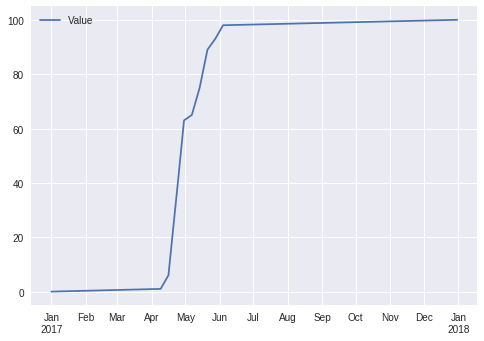

In [0]:
#visualize 2017 percent planted data
interpolated.plot()

In [0]:
#Now we need to figure out how to do this for EVERY YEAR in a specific phase in Illinois

In [0]:
#use the saved csv
df = pd.read_csv('progress_data_raw.csv')

#select state and phase
df = df[df.state_name == 'ILLINOIS']
pl = df['unit_desc'] == 'PCT PLANTED'
dfp = df[['week_ending','Value']][pl]

#convert week_ending column to datetime format. set year to index.
dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
dfp.set_index('week_ending', inplace = True)

#need to extend date range so it runs from 01-01-1981 to 12-31-2017 and has daily points not weekly.
ix = pd.date_range(start= '01-01-1981', end = '12-31-2017', freq = 'D')
dfp = dfp.reindex(ix)

#find all the unique years
yrs = list(dfp.index.year.unique())

df_all = pd.DataFrame()
for y in yrs:
  df_year = dfp.loc[str(y)]
  df_year.iloc[0,0] = 0
  df_year.iloc[-1] = 100
  
  resampled_dfp = df_year.resample('D')
  interpolated_dfp = resampled_dfp.interpolate(method = 'linear')
  
  df_all = pd.concat([df_all, interpolated_dfp], axis = 0)

In [0]:
#Now we need to figure out how to do this for every year in EVERY PHASE in Illinois

In [0]:
#Note: This function fails to interpolate between year-01-01 to year-12-31
#use the saved csv
df = pd.read_csv('progress_data_raw.csv')
df = df[df.state_name == 'ILLINOIS']

#list all the phases
phase = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH','PCT DENTED', 'PCT MATURE'] #removed PCT HARVESTED b/c duplicate dates

df_all_phases_all_years = pd.DataFrame()

for p in phase:
  pl = df['unit_desc'] == p
  dfp = df[['week_ending','Value']][pl]
  
  dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
  dfp.set_index('week_ending', inplace = True)
  
  yrs = list(dfp.index.year.unique())
  
  df_specific_phase_all_years = pd.DataFrame() #prime the empty dataframe to collect specific phase data for every year
  
  for y in yrs:
    df_year = dfp.loc[str(y)]
    df_year.iloc[0,0] = 0
    df_year.iloc[-1,0] = 100
  
    resampled_dfp = df_year.resample('D')
    interpolated_dfp = resampled_dfp.interpolate(method = 'linear')
  
    df_specific_phase_all_years = pd.concat([df_specific_phase_all_years, interpolated_dfp], axis = 0)
    
  df_all_phases_all_years = pd.concat([df_all_phases_all_years, df_specific_phase_all_years], axis = 1)
  
  print(p)
  
df_all_phases_all_years.columns = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH', 'PCT DENTED', 'PCT MATURE'] #still missing harvested

#there will be a lot of NaN values b/c while the crop is in one phase it cannot be in the other. rows should usually only have one value.
df_all_phases_all_years.fillna(0, inplace = True)

#df_all_phases_all_years.to_csv('illinois_development_data.csv', header = True, index = True)

PCT PLANTED
PCT SILKING
PCT DOUGH
PCT DENTED
PCT MATURE


In [0]:
#Note: This function DOES interpolate between year-01-01 to year-12-31

#use the saved csv
df = pd.read_csv('progress_data_raw.csv')
df = df[df.state_name == 'ILLINOIS']

#list all the phases
phase = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH','PCT DENTED', 'PCT MATURE'] #removed PCT HARVESTED b/c duplicate dates

df_all_phases_all_years = pd.DataFrame()

for p in phase:
  pl = df['unit_desc'] == p
  dfp = df[['week_ending','Value']][pl]
  
  dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
  dfp.set_index('week_ending', inplace = True)
  
  yrs = list(dfp.index.year.unique())
  
  df_specific_phase_all_years = pd.DataFrame() #prime the empty dataframe to collect specific phase data for every year
  
  for y in yrs:
    
    #make sure existing data starts with 0 and ends in 100 even when index does not extend full year yet
    df_year = dfp.loc[str(y)]
    df_year.iloc[0,0] = 0
    df_year.iloc[-1,0] = 100
    
    #extend index to full year
    ix = pd.date_range(start= '01-01-'+str(y), end = '12-31-'+str(y), freq = 'D')
    df_year = df_year.reindex(ix)
    
    #make sure new extended index now starts with 0 and ends in 100
    df_year.iloc[0,0] = 0
    df_year.iloc[-1,0] = 100
    
    #linearly interpolate data
    resampled_dfp = df_year.resample('D')
    interpolated_dfp = resampled_dfp.interpolate(method = 'linear')
  
    df_specific_phase_all_years = pd.concat([df_specific_phase_all_years, interpolated_dfp], axis = 0)
    
  df_all_phases_all_years = pd.concat([df_all_phases_all_years, df_specific_phase_all_years], axis = 1)
  
  print(p)
  
df_all_phases_all_years.columns = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH', 'PCT DENTED', 'PCT MATURE'] #still missing harvested

#there will be a lot of NaN values b/c while the crop is in one phase it cannot be in the other. this is not true!!!

df_all_phases_all_years.to_csv('illinois_development_data.csv', header = True, index = True)


PCT PLANTED
PCT SILKING
PCT DOUGH
PCT DENTED
PCT MATURE


In [0]:
#figure out how to convert cdf to pdf
import matplotlib.pyplot as plt
import copy
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)

In [0]:
#work with subset of data

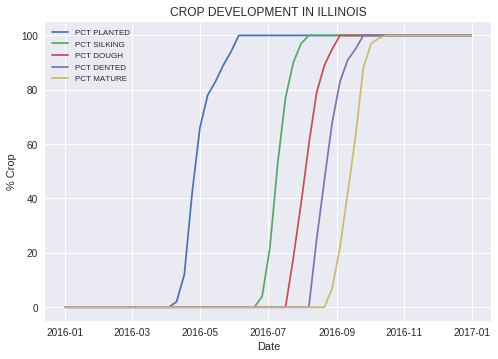

In [0]:
#plot what the development data currently looks like. this is a CDF. we want a PDF.
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)
df.index = pd.to_datetime(df.index)
df = df.loc['2016-01-01':'2016-12-31']

for i in df.columns:
  dfp = copy.deepcopy(df[[str(i)]])
  
  x = dfp.index
  y = dfp[str(i)]

  plt.plot(x,y.values,label = str(i))
  
plt.title('CROP DEVELOPMENT IN ILLINOIS')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

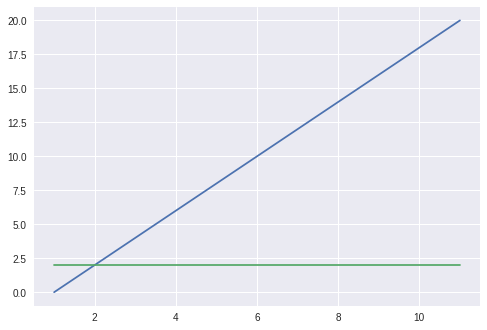

In [0]:
#testing out gradient to take derivative of series
import numpy as np
test = {'counter':[1,2,3,4,5,6,7,8,9,10,11], 'cats':[0,2,4,6,8,10,12,14,16,18,20]}
test = pd.DataFrame.from_dict(test)
test.set_index('counter', inplace = True)

y = test.cats.values
j = np.gradient(y)

test['gradient'] = j

x =test.index
y1 = test.cats.values
y2 = test.gradient.values

plt.plot(x,y1)
plt.plot(x,y2)
plt.show()


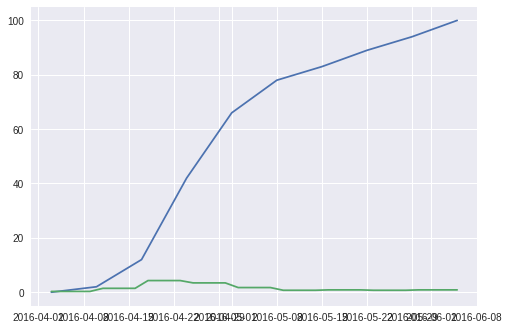

In [0]:
#Applied np.gradient to subset of data and looks pretty bad
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)
df.index = pd.to_datetime(df.index)
#found that 100 is reach on 2016-06-05 really need to reinteprolate data to fix this. Start on 2016-04-03
df = df.loc['2016-04-03':'2016-06-05']

dfp = copy.deepcopy(df[['PCT PLANTED']])

#np.gradient(dfp.values)

dfp['gradient'] = np.gradient(dfp['PCT PLANTED'].values)

x = dfp.index
y1 = dfp['PCT PLANTED']
y2 = dfp['gradient']

plt.plot(x,y1)
plt.plot(x,y2)
plt.show()


In [0]:
#try using numpy.diff on percent planted data 

#read interolated IL progress data
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)
df.index = pd.to_datetime(df.index)

#pick out one year
df = df.loc['2016-01-01':'2016-12-31']

#make a seperate dataframe to preserve original. also select PCT PLANTED
dfp = copy.deepcopy(df[['PCT PLANTED']])

#difference between points is 1 day
dx = 1

y = dfp['PCT PLANTED'].values
dy = np.diff(y)

dydx = dy/dx

In [0]:
#complaning the dy/dx is not came length as dfp.index which is true. dydx should be one less. added on number on end just for now.
dydx= np.append(dydx, [[0]])

#check length of index is same length of derivatives after above adjustment
len(dydx) == len(dfp.index)

True

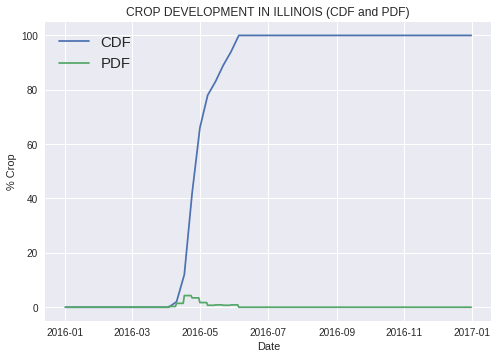

In [0]:
#add derivative column 
dfp['derivative'] = dydx

#plot the CDF(PCT PLANTED) and PDF(derivative)
x = dfp.index
y1 = dfp['PCT PLANTED']
y2 = dfp['derivative']



plt.plot(x, y1, label = 'CDF')
plt.plot(x,y2, label = 'PDF')

plt.title('CROP DEVELOPMENT IN ILLINOIS (CDF and PDF)')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 15})

plt.show()

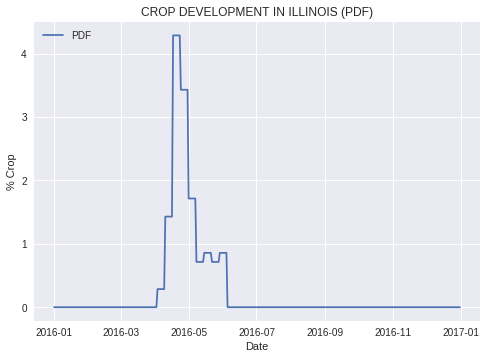

In [0]:
#replot only PDF to inspect

x = dfp.index
y2 = dfp['derivative']

plt.plot(x,y2, label = 'PDF')

plt.title('CROP DEVELOPMENT IN ILLINOIS (PDF)')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 10})

plt.show()

In [0]:
#calculate area under PDF to make sure it is correct. the area under the pdf must be 1 (or 100%).

import numpy as np
from numpy import trapz

# Compute the area using the composite trapezoidal rule.
area = trapz(dydx, dx=1)
print("area =", area)

area = 100.0


In [0]:
#now we need to perform the above operation for every phase in Illinois in 2016 to make sure rows now add to 100

import copy

#read interolated IL progress data
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)
df.index = pd.to_datetime(df.index)

#make sure only using 2016
df = copy.deepcopy(df.loc['2016-01-01':'2016-12-31'])

#make empty df for derivatives. use copy of index of above df.
df_deriv = pd.DataFrame(index = df.index.copy())

for i in df.columns:
  dfp = copy.deepcopy(df[[str(i)]])
  
  dx = 1
  
  y = dfp[str(i)].values
  dy = np.diff(y)
  
  dydx = dy/dx
  
  dydx= np.append(dydx, [[0]])
  
  df_deriv[str(i) + '_deriv'] = dydx

In [0]:
#rows are still not adding to 100 (or anywhere close!!!) for above df created with loop
df_deriv.head()

,PCT PLANTED_deriv,PCT SILKING_deriv,PCT DOUGH_deriv,PCT DENTED_deriv,PCT MATURE_deriv
2016-01-01,0.0,0.0,0.0,0.0,0.0
2016-01-02,0.0,0.0,0.0,0.0,0.0
2016-01-03,0.0,0.0,0.0,0.0,0.0
2016-01-04,0.0,0.0,0.0,0.0,0.0
2016-01-05,0.0,0.0,0.0,0.0,0.0


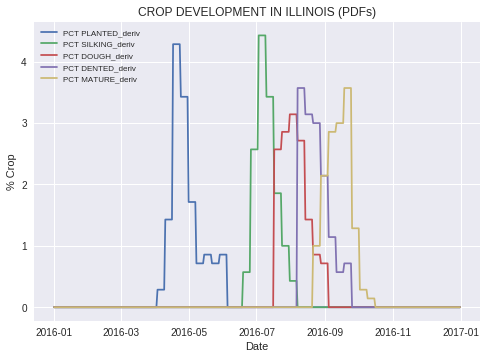

In [0]:
#Plot PDFs all together

import matplotlib.pyplot as plt

for i in df_deriv.columns:
  dfp = copy.deepcopy(df_deriv[[str(i)]])
  
  x = dfp.index
  y = dfp[str(i)]

  plt.plot(x,y.values,label = str(i))

plt.title('CROP DEVELOPMENT IN ILLINOIS (PDFs)')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

In [0]:
#sum across rows and add as new column
df_deriv['sum'] = df_deriv.sum(axis=1)
df_deriv.head()

,PCT PLANTED_deriv,PCT SILKING_deriv,PCT DOUGH_deriv,PCT DENTED_deriv,PCT MATURE_deriv,sum
2016-01-01,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-02,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-03,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-04,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,0.0,0.0,0.0,0.0,0.0,0.0


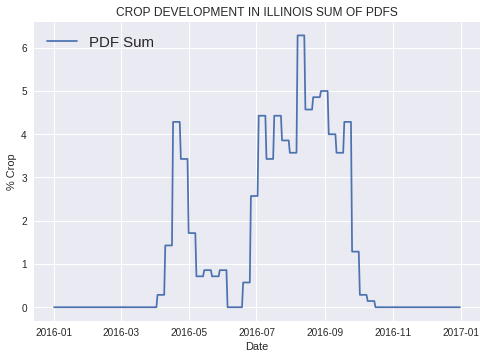

In [0]:
#plot the row sums to see what value they add to.

x = df_deriv.index
y = df_deriv['sum']
plt.plot(x,y.values, label = 'PDF Sum')

plt.title('CROP DEVELOPMENT IN ILLINOIS SUM OF PDFS')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 15})
plt.show()

In [0]:
#summing PDFs did not work! now we will only work with the CDF.

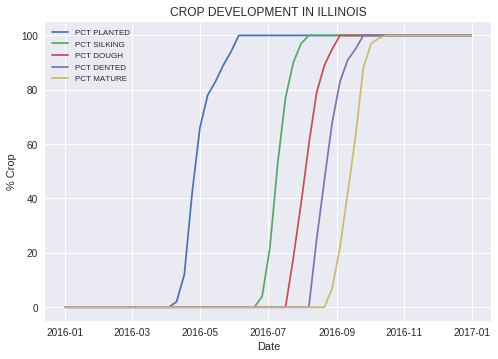

In [3]:
#review what CDF looks like
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)
df.index = pd.to_datetime(df.index)
df = df.loc['2016-01-01':'2016-12-31']

for i in df.columns:
  dfp = copy.deepcopy(df[[str(i)]])
  
  x = dfp.index
  y = dfp[str(i)]

  plt.plot(x,y.values,label = str(i))
  
plt.title('CROP DEVELOPMENT IN ILLINOIS')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

In [4]:
df.head()

,PCT PLANTED,PCT SILKING,PCT DOUGH,PCT DENTED,PCT MATURE
2016-01-01,0.0,0.0,0.0,0.0,0.0
2016-01-02,0.0,0.0,0.0,0.0,0.0
2016-01-03,0.0,0.0,0.0,0.0,0.0
2016-01-04,0.0,0.0,0.0,0.0,0.0
2016-01-05,0.0,0.0,0.0,0.0,0.0


In [0]:
#planted should be PCT PLANTED - PCT SILKING
df['planted-silking'] = df['PCT PLANTED'] - df['PCT SILKING']

#silking should be PCT SILKING - PCT DOUGH
df['silking-dough'] = df['PCT SILKING'] - df['PCT DOUGH']

#doughing should be PCT DOUGH - PCT DENTED
df['dough-dented'] = df['PCT DOUGH'] - df['PCT DENTED']

#dented should be PCT DENTED - PCT MATURE
df['dented-mature'] = df['PCT DENTED'] - df['PCT MATURE']


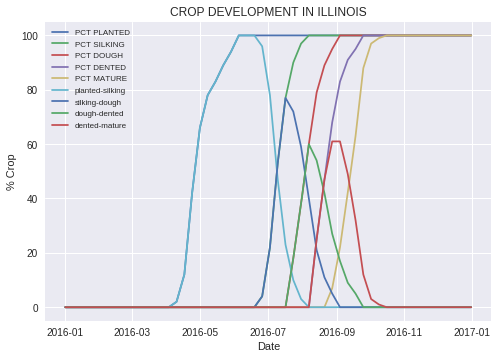

In [12]:
for i in df.columns:
  dfp = copy.deepcopy(df[[str(i)]])
  
  x = dfp.index
  y = dfp[str(i)]

  plt.plot(x,y.values,label = str(i))
  
plt.title('CROP DEVELOPMENT IN ILLINOIS')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

In [0]:
#make a new dataframe of the adjusted phases
df_altered = df[['planted-silking', 'silking-dough', 'dough-dented', 'dented-mature', 'PCT MATURE']].copy()
df_altered['sum'] = df_altered.sum(axis = 1)

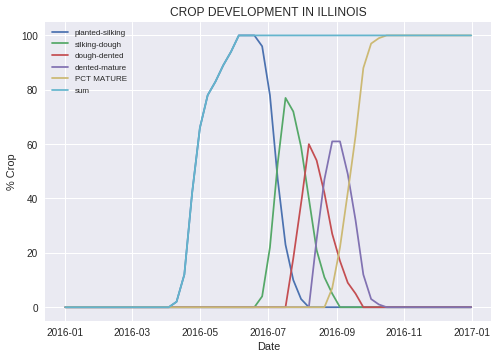

In [26]:
#use loop to plot new data frame
for i in df_altered.columns:
  dfp = copy.deepcopy(df_altered[[str(i)]])
  
  x = dfp.index
  y = dfp[str(i)]

  plt.plot(x,y.values,label = str(i))
  
plt.title('CROP DEVELOPMENT IN ILLINOIS')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

In [54]:
#combine six distinct phases such that there are only three distinct phases. do this before subtracting adjacent CDFs.
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)
df.index = pd.to_datetime(df.index)
df = df.loc['2016-01-01':'2016-12-31']

df['vegetative'] = df['PCT PLANTED'] + df['PCT SILKING']
df['early_grain'] = df['PCT SILKING'] + df['PCT DOUGH']
df['late_grain'] = df['PCT DOUGH'] + df['PCT MATURE'] 
 
df_combined = df[['vegetative', 'early_grain', 'late_grain']]
df_combined.head()

,vegetative,early_grain,late_grain
2016-01-01,0.0,0.0,0.0
2016-01-02,0.0,0.0,0.0
2016-01-03,0.0,0.0,0.0
2016-01-04,0.0,0.0,0.0
2016-01-05,0.0,0.0,0.0


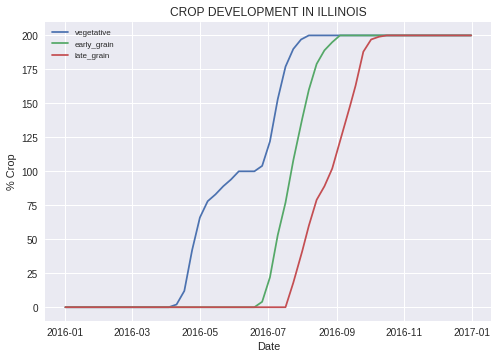

In [45]:
#use loop to plot new data frame
for i in df_combined.columns:
  dfp = copy.deepcopy(df_combined[[str(i)]])
  
  x = dfp.index
  y = dfp[str(i)]

  plt.plot(x,y.values,label = str(i))
  
plt.title('CROP DEVELOPMENT IN ILLINOIS')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

In [0]:
#subtract adjacent CDFs

df_combined['vegetative_altered'] = df_combined['vegetative'] - df_combined['early_grain']

df_combined['early_grain_altered'] = df_combined['early_grain'] - df_combined['late_grain']

#df_combined['late_grain_altered'] = df['late_grain'] - df['early_grain']

# #dented should be PCT DENTED - PCT MATURE
# df['dented-mature'] = df['PCT DENTED'] - df['PCT MATURE']

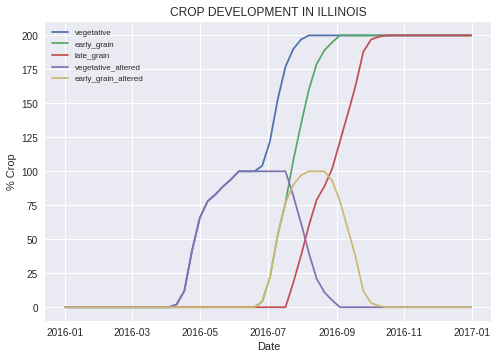

In [56]:
#use loop to plot new data frame. Problem: sum is greater than 100%.
for i in df_combined.columns:
  dfp = copy.deepcopy(df_combined[[str(i)]])
  
  x = dfp.index
  y = dfp[str(i)]

  plt.plot(x,y.values,label = str(i))
  
plt.title('CROP DEVELOPMENT IN ILLINOIS')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()

In [57]:
df = pd.read_csv('illinois_development_data.csv', index_col = 0, header = 0)
df.index = pd.to_datetime(df.index)
df = df.loc['2016-01-01':'2016-12-31']

#subtract adjacent CDFs first.

#planted should be PCT PLANTED - PCT SILKING
df['planted-silking'] = df['PCT PLANTED'] - df['PCT SILKING']

#silking should be PCT SILKING - PCT DOUGH
df['silking-dough'] = df['PCT SILKING'] - df['PCT DOUGH']

#doughing should be PCT DOUGH - PCT DENTED
df['dough-dented'] = df['PCT DOUGH'] - df['PCT DENTED']

#dented should be PCT DENTED - PCT MATURE
df['dented-mature'] = df['PCT DENTED'] - df['PCT MATURE']

#now the phases into three.

df['vegetative'] = df['planted-silking'] + df['silking-dough']
df['early_grain'] = df['silking-dough'] + df['dough-dented']
df['late_grain'] = df['dough-dented'] + df['PCT MATURE'] 
 
df_combined = df[['vegetative', 'early_grain', 'late_grain']]
df_combined.head()

,vegetative,early_grain,late_grain
2016-01-01,0.0,0.0,0.0
2016-01-02,0.0,0.0,0.0
2016-01-03,0.0,0.0,0.0
2016-01-04,0.0,0.0,0.0
2016-01-05,0.0,0.0,0.0


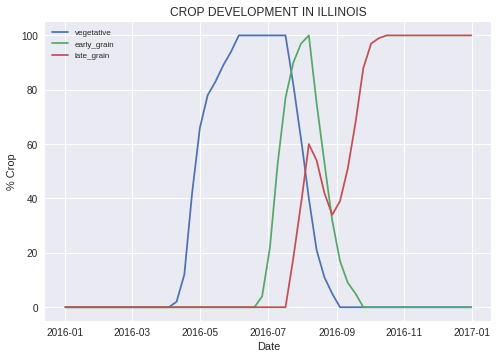

In [58]:
#use loop to plot new data frame. Problem: sums greater than 100, looks funny...
for i in df_combined.columns:
  dfp = copy.deepcopy(df_combined[[str(i)]])
  
  x = dfp.index
  y = dfp[str(i)]

  plt.plot(x,y.values,label = str(i))
  
plt.title('CROP DEVELOPMENT IN ILLINOIS')
plt.xlabel('Date')
plt.ylabel('% Crop')
plt.legend(loc = 'upper left', prop={'size': 8})
plt.show()